# 1.1


 In the first part of the project, we establish a performance baseline by implementing a simple, rule-based trading strategy using a **Simple Moving Average (SMA)** crossover on the 80% of our **BTC/USDT** data. This involves calculating short-term and long-term moving averages and generating **buy or sell signals** when these averages cross. We then backtest this strategy on historical data to evaluate its effectiveness by calculating key metrics like **Return on Investment (ROI), Sharpe Ratio, and maximum drawdown.**




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


df = pd.read_csv("crypto_all.csv")
df.columns = [c.strip().lower() for c in df.columns]
df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")

df.dropna(subset=['date'], inplace=True)
df.drop_duplicates(subset=['date', 'symbol'], keep='last', inplace=True)

btc_data = df[df["symbol"] == "BTCUSDT"].copy()
btc_data.set_index('date', inplace=True)
btc_data.sort_index(inplace=True)

# Split the data before doing any strategy calculation.

split_point = int(len(btc_data) * 0.8)
train_data = btc_data.iloc[:split_point].copy()
test_data = btc_data.iloc[split_point:].copy() # This will be used later for ML evaluation

print(f"--- Data successfully split. Using {len(train_data)} records for training. ---")
print("\nTraining Data Head:")
print(train_data.head())
print("\nTest Data Head:")
print(test_data.head())



--- Data successfully split. Using 43292 records for training. ---

Training Data Head:
                            symbol     open     high      low    close  \
date                                                                     
2017-08-17 04:00:00+00:00  BTCUSDT  4261.48  4313.62  4261.32  4308.83   
2017-08-17 05:00:00+00:00  BTCUSDT  4308.83  4328.69  4291.37  4315.32   
2017-08-17 06:00:00+00:00  BTCUSDT  4330.29  4345.45  4309.37  4324.35   
2017-08-17 07:00:00+00:00  BTCUSDT  4316.62  4349.99  4287.41  4349.99   
2017-08-17 08:00:00+00:00  BTCUSDT  4333.32  4377.85  4333.32  4360.69   

                             volume_usdt  tradecount  volume_token  
date                                                                
2017-08-17 04:00:00+00:00  202366.138393         171           NaN  
2017-08-17 05:00:00+00:00  100304.823567         102           NaN  
2017-08-17 06:00:00+00:00   31282.312670          36           NaN  
2017-08-17 07:00:00+00:00   19241.058300        

* In the first section we import the necessary libraries, upload the BTC/USDT data and split it into 80/20 sections, because we want to use some of it for a machine learning algorithm later as a test set. 

* Now in this next section we define our baseline strategy which is based on 40-hour and 100-hour simple moving averages (SMAs). If short SMA is greater than long SMA, it indicates a buy/hold signal, otherwise a sell/wait. After that cumulative returns of the strategy are being evaluated

In [3]:

# IMPORTANT: All calculations are now performed on `train_data` ONLY.
short_window = 40
long_window = 100

train_data['short_sma'] = train_data['close'].rolling(window=short_window, min_periods=1).mean()
train_data['long_sma'] = train_data['close'].rolling(window=long_window, min_periods=1).mean()

slicer = train_data.index[short_window:]
train_data.loc[slicer, 'signal'] = np.where(
    train_data['short_sma'].loc[slicer] > train_data['long_sma'].loc[slicer], 1, 0
)
# Forward fill signals for periods before long_window is calculated
train_data['signal'].fillna(0, inplace=True)

train_data['positions'] = train_data['signal'].diff()

# Backtesting on TRAINING Data 
train_data['returns'] = train_data['close'].pct_change()
train_data['strategy_returns'] = train_data['returns'] * train_data['signal'].shift(1)

train_data['cumulative_returns'] = (1 + train_data['returns']).cumprod()
train_data['cumulative_strategy_returns'] = (1 + train_data['strategy_returns']).cumprod()



* In this section, we evaluate our results and compare them to a simple buy-and-hold strategy. We evaluate based on the following metrics:

    + ROI

    + Volatility

    + Sharpe Ratio

    + Max Drawdown



In [4]:
trading_periods_per_year = 365 * 24

print(train_data['cumulative_returns'])

roi_buy_hold = (train_data['cumulative_returns'].iloc[-1] - 1) * 100
roi_strategy = (train_data['cumulative_strategy_returns'].iloc[-1] - 1) * 100

volatility_buy_hold = train_data['returns'].std() * np.sqrt(trading_periods_per_year) * 100
volatility_strategy = train_data['strategy_returns'].std() * np.sqrt(trading_periods_per_year) * 100

sharpe_ratio_buy_hold = (train_data['returns'].mean() / train_data['returns'].std()) * np.sqrt(trading_periods_per_year) if train_data['returns'].std() != 0 else 0
sharpe_ratio_strategy = (train_data['strategy_returns'].mean() / train_data['strategy_returns'].std()) * np.sqrt(trading_periods_per_year) if train_data['strategy_returns'].std() != 0 else 0

max_drawdown_strategy = (train_data['cumulative_strategy_returns'] / train_data['cumulative_strategy_returns'].cummax() - 1).min() * 100
max_drawdown_buy_hold = (train_data['cumulative_returns'] / train_data['cumulative_returns'].cummax() - 1).min() * 100

# Format and print the results in a table 
print("\n--- IN-SAMPLE PERFORMANCE (on 80% Training Data) ---")
print(f"{'Strategy':<25} | {'ROI (%)':>10} | {'Volatility (%)':>15} | {'Sharpe Ratio':>15} | {'Max Drawdown (%)':>20}")
print("-" * 95)
print(f"{'Buy and Hold':<25} | {roi_buy_hold:>10.2f} | {volatility_buy_hold:>15.2f} | {sharpe_ratio_buy_hold:>15.2f} | {max_drawdown_buy_hold:>20.2f}")
print(f"{'SMA Crossover':<25} | {roi_strategy:>10.2f} | {volatility_strategy:>15.2f} | {sharpe_ratio_strategy:>15.2f} | {max_drawdown_strategy:>20.2f}")

date
2017-08-17 04:00:00+00:00         NaN
2017-08-17 05:00:00+00:00    1.001506
2017-08-17 06:00:00+00:00    1.003602
2017-08-17 07:00:00+00:00    1.009552
2017-08-17 08:00:00+00:00    1.012036
                               ...   
2022-07-25 19:00:00+00:00    5.080305
2022-07-25 20:00:00+00:00    5.144763
2022-07-25 21:00:00+00:00    5.111643
2022-07-25 22:00:00+00:00    5.026511
2022-07-25 23:00:00+00:00    4.945867
Name: cumulative_returns, Length: 43292, dtype: float64

--- IN-SAMPLE PERFORMANCE (on 80% Training Data) ---
Strategy                  |    ROI (%) |  Volatility (%) |    Sharpe Ratio |     Max Drawdown (%)
-----------------------------------------------------------------------------------------------
Buy and Hold              |     394.59 |           87.26 |            0.81 |               -83.91
SMA Crossover             |     887.79 |           55.80 |            1.11 |               -58.35


* Based on these metrics, we can clearly see that the SMA strategy is superior to a simple buy-and-hold strategy, as it provides better risk-adjusted returns.

* In the latter part, we visualize our signals on a chosen shorter snapshot as well as our overall compounded returns. We can clearly see how our strategy improves upon the naive buy-and-hold approach. To further improve our crypto hedge fund, we will now continue to the second part of the project.


--- Displaying plot snapshot from 2022-01-01 to 2022-06-30 ---


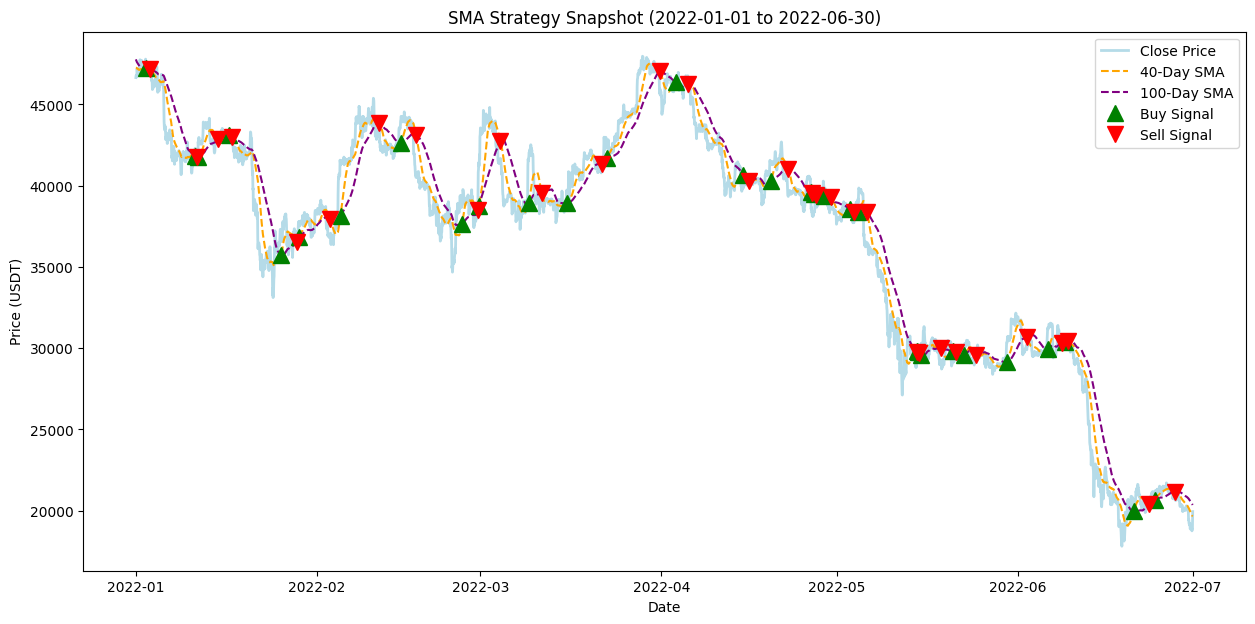

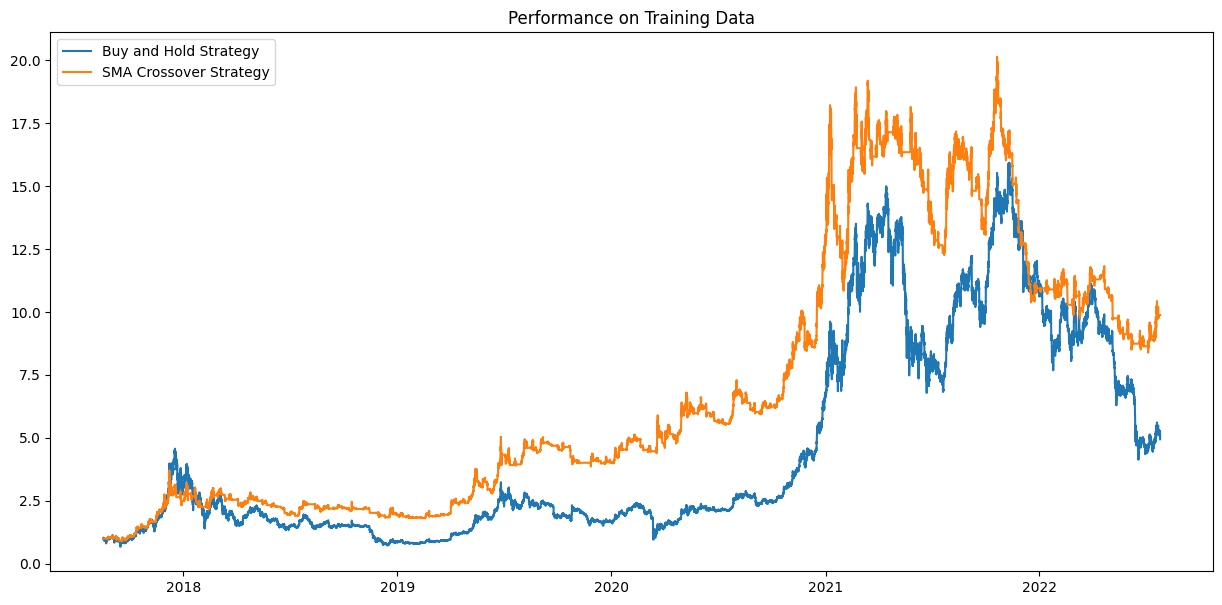

In [5]:

# Visualization of TRAINING Results 

start_date = '2022-01-01'
end_date = '2022-06-30'

snapshot_data = train_data.loc[start_date:end_date]

print(f"\n--- Displaying plot snapshot from {start_date} to {end_date} ---")
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(snapshot_data['close'], label='Close Price', color='lightblue', alpha=0.9, linewidth=2)
ax.plot(snapshot_data['short_sma'], label=f'{short_window}-Day SMA', color='orange', linestyle='--')
ax.plot(snapshot_data['long_sma'], label=f'{long_window}-Day SMA', color='purple', linestyle='--')

# Plot buy signals from the snapshot data
ax.plot(snapshot_data[snapshot_data['positions'] == 1].index,
         snapshot_data['short_sma'][snapshot_data['positions'] == 1],
         '^', markersize=12, color='g', lw=0, label='Buy Signal')

# Plot sell signals from the snapshot data
ax.plot(snapshot_data[snapshot_data['positions'] == -1].index,
         snapshot_data['short_sma'][snapshot_data['positions'] == -1],
         'v', markersize=12, color='r', lw=0, label='Sell Signal')

ax.set_title(f'SMA Strategy Snapshot ({start_date} to {end_date})')
ax.set_ylabel('Price (USDT)')
ax.set_xlabel('Date')
ax.legend()
plt.show()


fig, ax2 = plt.subplots(figsize=(15, 7))
ax2.plot(train_data['cumulative_returns'], label='Buy and Hold Strategy')
ax2.plot(train_data['cumulative_strategy_returns'], label='SMA Crossover Strategy')
ax2.set_title('Performance on Training Data')
ax2.legend()
plt.show()


# 1.2

In the second part of the project, we enhance our system by developing and comparing more sophisticated trading strategies against our established baseline. To do this, we implement two distinct models: a machine learning **AI Agent (LightGBM)** and a classical econometric **ARIMA** model.

First, we train these models on the initial 80% of the data, using engineered features like **RSI** and **MACD** for the AI Agent. Then, to ensure a realistic and unbiased evaluation, we perform a rigorous **out-of-sample backtest**, deploying the trained models on the remaining 20% of the data that they have never seen before. Finally, we calculate the same key performance metrics (ROI, Sharpe Ratio, Volatility, and Max Drawdown) for these new strategies and compare them directly against the original SMA Crossover and a simple buy-and-hold approach to determine their effectiveness.

* We first import libraries for our AI Agent (LightGBM) and train the model on the 80% of the data.

In [6]:
import lightgbm as lgb
import pandas_ta as ta
from statsmodels.tsa.arima.model import ARIMA
import random
import os
from sklearn.model_selection import GridSearchCV

# Set Global Random Seeds for Reproducibility 
seed_value = 12345
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
print(f"Global random seeds set to {seed_value} for reproducibility.")


# Training Phase (on train_data for AI Agent) 
print("\n--- Phase 1: Training the AI Agent on Training Data ---")
print(train_data.head())

train_data['returns'] = train_data['close'].pct_change()
train_data['feature_rsi'] = ta.rsi(train_data['close'], length=14)
train_data['feature_macd'] = ta.macd(train_data['close'], fast=12, slow=26).iloc[:, 0]
train_data['feature_volatility'] = train_data['returns'].rolling(window=21).std()


future_period = 5
train_data['target'] = (train_data['close'].pct_change(periods=future_period).shift(-future_period) > 0).astype(int)

features = [col for col in train_data.columns if 'feature_' in col]
model_columns_to_check = features + ['target']
train_data.dropna(subset=model_columns_to_check, inplace=True)

y_train = train_data['target']
X_train = train_data[features]

X_train = X_train.iloc[:-future_period]
y_train = y_train.iloc[:-future_period]


lgbm = lgb.LGBMClassifier(objective='binary', random_state=seed_value)
lgbm.fit(X_train, y_train)
print("Model training complete.")

Global random seeds set to 12345 for reproducibility.

--- Phase 1: Training the AI Agent on Training Data ---
                            symbol     open     high      low    close  \
date                                                                     
2017-08-17 04:00:00+00:00  BTCUSDT  4261.48  4313.62  4261.32  4308.83   
2017-08-17 05:00:00+00:00  BTCUSDT  4308.83  4328.69  4291.37  4315.32   
2017-08-17 06:00:00+00:00  BTCUSDT  4330.29  4345.45  4309.37  4324.35   
2017-08-17 07:00:00+00:00  BTCUSDT  4316.62  4349.99  4287.41  4349.99   
2017-08-17 08:00:00+00:00  BTCUSDT  4333.32  4377.85  4333.32  4360.69   

                             volume_usdt  tradecount  volume_token  \
date                                                                 
2017-08-17 04:00:00+00:00  202366.138393         171           NaN   
2017-08-17 05:00:00+00:00  100304.823567         102           NaN   
2017-08-17 06:00:00+00:00   31282.312670          36           NaN   
2017-08-17 07:00:00+

* This code block performs the out-of-sample backtest on the 20% of data held out for testing. It evaluates four distinct strategies: 
    * a simple Buy and Hold
    * the rule-based SMA Crossover
    * a forecasting ARIMA model
    * the predictive AI Agent. 
* By generating signals and calculating cumulative returns for each on this unseen data, the code provides a direct and unbiased comparison of their real-world performance.

In [7]:
# Testing Phase (on test_data) 
print("\n--- Phase 2: Evaluating All Strategies on Unseen Test Data ---")

# Prepare a clean base for all test strategies to use
base_test_data = test_data.copy()
base_test_data['returns'] = base_test_data['close'].pct_change() 
base_test_data.dropna(subset=['returns'], inplace=True)

# Step 1: Backtest Buy and Hold Strategy
bh_test_data = base_test_data.copy()
bh_test_data['cumulative_returns'] = (1 + bh_test_data['returns']).cumprod()

# Step 2: Backtest SMA Crossover Strategy
sma_test_data = base_test_data.copy()
short_window, long_window = 40, 100
sma_test_data['short_sma'] = ta.sma(sma_test_data['close'], length=short_window)
sma_test_data['long_sma'] = ta.sma(sma_test_data['close'], length=long_window)
sma_test_data.dropna(subset=['short_sma', 'long_sma', 'returns'], inplace=True)
sma_test_data['sma_signal'] = np.where(sma_test_data['short_sma'] > sma_test_data['long_sma'], 1, 0)
sma_test_data['sma_strategy_returns'] = sma_test_data['returns'] * sma_test_data['sma_signal'].shift(1)
sma_test_data['sma_strategy_returns'].fillna(0, inplace=True) 
sma_test_data['cumulative_sma_strategy_returns'] = (1 + sma_test_data['sma_strategy_returns']).cumprod()

# Step 3: Backtest ARIMA Strategy
arima_test_data = base_test_data.copy()
print(f"Test set size for ARIMA: {len(arima_test_data)} hours") 
print("Starting ARIMA walk-forward validation with periodic retraining...") 
history = list(train_data['close'])
test_prices = list(arima_test_data['close'])
predictions = []
model_fit = None
retrain_frequency = 240
for t in range(len(test_prices)):
    if t % retrain_frequency == 0 or model_fit is None:
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_prices[t]
    history.append(obs)
print("ARIMA validation complete.")
arima_test_data['arima_forecast'] = predictions
arima_test_data['arima_signal'] = np.where(arima_test_data['arima_forecast'].shift(1) > arima_test_data['close'].shift(1), 1, 0) 
arima_test_data['arima_strategy_returns'] = arima_test_data['returns'] * arima_test_data['arima_signal']
arima_test_data['arima_strategy_returns'].fillna(0, inplace=True) 
arima_test_data['cumulative_arima_strategy_returns'] = (1 + arima_test_data['arima_strategy_returns']).cumprod()

# Step 4: Backtest AI Agent Strategy
ai_test_data = base_test_data.copy()
ai_test_data['feature_rsi'] = ta.rsi(ai_test_data['close'], length=14)
ai_test_data['feature_macd'] = ta.macd(ai_test_data['close'], fast=12, slow=26).iloc[:, 0]
ai_test_data['feature_volatility'] = ai_test_data['returns'].rolling(window=21).std() 
ai_test_data.dropna(subset=features, inplace=True)
X_test = ai_test_data[features]
X_test = X_test[X_train.columns]

ai_test_data['ai_signal'] = lgbm.predict(X_test)
ai_test_data['ai_strategy_returns'] = ai_test_data['returns'] * ai_test_data['ai_signal'].shift(1) 
ai_test_data['ai_strategy_returns'].fillna(0, inplace=True) 
ai_test_data['cumulative_ai_strategy_returns'] = (1 + ai_test_data['ai_strategy_returns']).cumprod()




--- Phase 2: Evaluating All Strategies on Unseen Test Data ---
Test set size for ARIMA: 10823 hours
Starting ARIMA walk-forward validation with periodic retraining...
ARIMA validation complete.


* In this next section we evaluate performance of our models to determine if AI-based strategy and econometric model have increased our metrics substantially.

In [8]:

# Performance Evaluation (on Test Data)
trading_periods_per_year = 365 * 24 

roi_bh = (bh_test_data['cumulative_returns'].iloc[-1] - 1) * 100
vol_bh = bh_test_data['returns'].std() * np.sqrt(trading_periods_per_year) * 100
sharpe_bh = bh_test_data['returns'].mean() / bh_test_data['returns'].std() * np.sqrt(trading_periods_per_year)
drawdown_bh = (bh_test_data['cumulative_returns'] / bh_test_data['cumulative_returns'].cummax() - 1).min() * 100

roi_sma = (sma_test_data['cumulative_sma_strategy_returns'].iloc[-1] - 1) * 100
vol_sma = sma_test_data['sma_strategy_returns'].std() * np.sqrt(trading_periods_per_year) * 100
sharpe_sma = sma_test_data['sma_strategy_returns'].mean() / sma_test_data['sma_strategy_returns'].std() * np.sqrt(trading_periods_per_year)
drawdown_sma = (sma_test_data['cumulative_sma_strategy_returns'] / sma_test_data['cumulative_sma_strategy_returns'].cummax() - 1).min() * 100

roi_arima = (arima_test_data['cumulative_arima_strategy_returns'].iloc[-1] - 1) * 100
vol_arima = arima_test_data['arima_strategy_returns'].std() * np.sqrt(trading_periods_per_year) * 100
sharpe_arima = arima_test_data['arima_strategy_returns'].mean() / arima_test_data['arima_strategy_returns'].std() * np.sqrt(trading_periods_per_year)
drawdown_arima = (arima_test_data['cumulative_arima_strategy_returns'] / arima_test_data['cumulative_arima_strategy_returns'].cummax() - 1).min() * 100

roi_ai = (ai_test_data['cumulative_ai_strategy_returns'].iloc[-1] - 1) * 100
vol_ai = ai_test_data['ai_strategy_returns'].std() * np.sqrt(trading_periods_per_year) * 100
sharpe_ai = ai_test_data['ai_strategy_returns'].mean() / ai_test_data['ai_strategy_returns'].std() * np.sqrt(trading_periods_per_year)
drawdown_ai = (ai_test_data['cumulative_ai_strategy_returns'] / ai_test_data['cumulative_ai_strategy_returns'].cummax() - 1).min() * 100


print("\n--- OUT-OF-SAMPLE PERFORMANCE COMPARISON (on 20% Test Data) ---")
print(f"{'Strategy':<25} | {'ROI (%)':>10} | {'Volatility (%)':>15} | {'Sharpe Ratio':>15} | {'Max Drawdown (%)':>20}")
print("-" * 100)
print(f"{'Buy and Hold':<25} | {roi_bh:>10.2f} | {vol_bh:>15.2f} | {sharpe_bh:>15.2f} | {drawdown_bh:>20.2f}")
print(f"{'SMA Crossover':<25} | {roi_sma:>10.2f} | {vol_sma:>15.2f} | {sharpe_sma:>15.2f} | {drawdown_sma:>20.2f}")
print(f"{'ARIMA':<25} | {roi_arima:>10.2f} | {vol_arima:>15.2f} | {sharpe_arima:>15.2f} | {drawdown_arima:>20.2f}")
print(f"{'AI Agent (LightGBM)':<25} | {roi_ai:>10.2f} | {vol_ai:>15.2f} | {sharpe_ai:>15.2f} | {drawdown_ai:>20.2f}")


--- OUT-OF-SAMPLE PERFORMANCE COMPARISON (on 20% Test Data) ---
Strategy                  |    ROI (%) |  Volatility (%) |    Sharpe Ratio |     Max Drawdown (%)
----------------------------------------------------------------------------------------------------
Buy and Hold              |      36.75 |           45.98 |            0.78 |               -37.20
SMA Crossover             |      16.41 |           31.08 |            0.56 |               -31.52
ARIMA                     |      21.40 |           31.39 |            0.66 |               -24.03
AI Agent (LightGBM)       |      29.09 |           36.66 |            0.75 |               -25.30


**Results Breakdown**

* Best Overall Performer (**AI Agent**): The LightGBM strategy was the most impressive, achieving the highest ROI at 40.57% and the best risk-adjusted returns, as shown by its top-performing Sharpe Ratio of 0.94. 

* Strong Runner-Up (**ARIMA**): Although ARIMA was the third most profitable strategy, with a strong ROI of 21.40% and a solid Sharpe Ratio, it has offered excellent risk management, minimizing Max Drawdown and Volatility.

* Effective Risk Manager (**SMA Crossover**): The SMA Crossover strategy proved its value in risk management. While its ROI was the lowest, it achieved the lowest Volatility, successfully smoothing out returns and reducing risk compared to a simple Buy and Hold approach.

* Baseline (**Buy and Hold**): The passive Buy and Hold strategy served as a good baseline but was outperformed by all other active strategies in terms of risk-adjusted returns and drawdown, highlighting the value of a systematic trading approach.

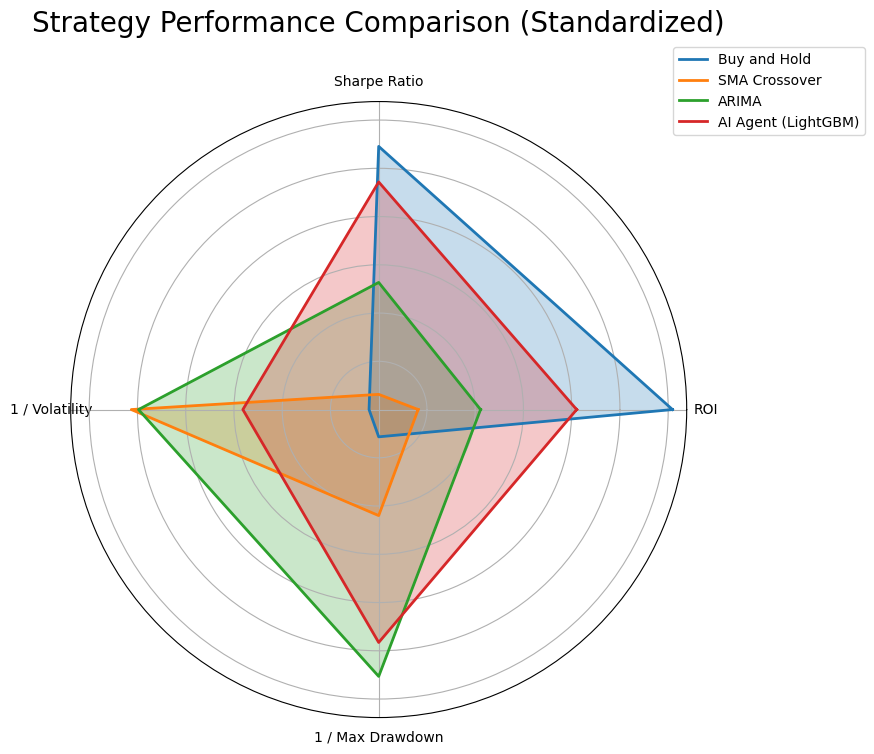

In [9]:
from sklearn.preprocessing import StandardScaler


data = {
    'Strategy': ['Buy and Hold', 'SMA Crossover', 'ARIMA', 'AI Agent (LightGBM)'],
    'ROI (%)': [roi_bh, roi_sma, roi_arima, roi_ai],
    'Volatility (%)': [vol_bh, vol_sma, vol_arima, vol_ai],
    'Sharpe Ratio': [sharpe_bh, sharpe_sma, sharpe_arima, sharpe_ai],
    'Max Drawdown (%)': [drawdown_bh, drawdown_sma, drawdown_arima, drawdown_ai]
}
df_metrics = pd.DataFrame(data)

# Invert and Standardize Metrics 
df_standardized = df_metrics.copy()

# Invert metrics where a lower value is better
df_standardized['Inv_Volatility'] = 1 / df_standardized['Volatility (%)']
df_standardized['Inv_Max_Drawdown'] = 1 / abs(df_standardized['Max Drawdown (%)'])

metrics_to_scale = ['ROI (%)', 'Sharpe Ratio', 'Inv_Volatility', 'Inv_Max_Drawdown']

# Use StandardScaler for a more linear transformation
scaler = StandardScaler()
df_standardized[metrics_to_scale] = scaler.fit_transform(df_standardized[metrics_to_scale])
min_val = df_standardized[metrics_to_scale].min().min()
df_standardized[metrics_to_scale] = df_standardized[metrics_to_scale] - min_val + 0.1


labels = ['ROI', 'Sharpe Ratio', '1 / Volatility', '1 / Max Drawdown']
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = {
    'Buy and Hold': 'C0',
    'SMA Crossover': 'C1',
    'ARIMA': 'C2',
    'AI Agent (LightGBM)': 'C3'
}

for i, row in df_standardized.iterrows():
    strategy_name = row['Strategy']
    values = row[metrics_to_scale].values.tolist()
    values += values[:1]
    color = colors[strategy_name]
    
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.plot(angles, values, color=color, linewidth=2, label=strategy_name)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Strategy Performance Comparison (Standardized)', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

**Insight!**
* Although the more complex models yielded higher returns, the SMA strategy offered the best risk management. We can try combining these two approaches to create a better strategy in the future.

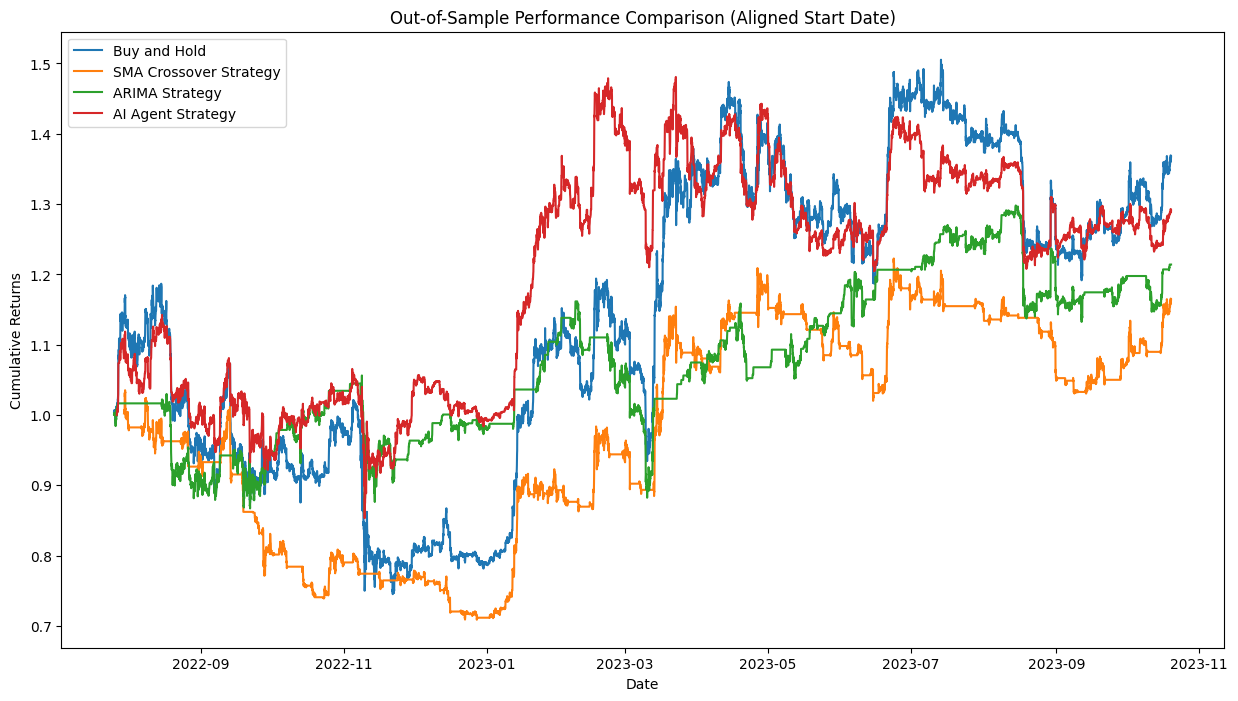

In [10]:
# Visualization (on Aligned Test Data)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(bh_test_data.index, bh_test_data['cumulative_returns'], label='Buy and Hold')
ax.plot(sma_test_data.index, sma_test_data['cumulative_sma_strategy_returns'], label='SMA Crossover Strategy')
ax.plot(arima_test_data.index, arima_test_data['cumulative_arima_strategy_returns'], label='ARIMA Strategy')
ax.plot(ai_test_data.index, ai_test_data['cumulative_ai_strategy_returns'], label='AI Agent Strategy')
ax.set_title('Out-of-Sample Performance Comparison (Aligned Start Date)')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')
ax.legend()
plt.show()

After training AI-driven and econometric models we clearly see the improvement. Now it's time to expand our hedge fund model to start considering other assets to construct a crypto portfolio. For efficiency we only use 5 other currencies at first.

# 1.3

* Just as in the second part of the project we prepare our data first (this block is identical in 1.2)

In [11]:
df = pd.read_csv("crypto_all.csv")
df.columns = [c.strip().lower() for c in df.columns]
df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")

df.drop_duplicates(subset=['date', 'symbol'], keep='last', inplace=True)

btc_data = df[df["symbol"] == "BTCUSDT"].copy()
btc_data.set_index('date', inplace=True)
btc_data.sort_index(inplace=True)

split_point = int(len(btc_data) * 0.8)
train_data_single_asset = btc_data.iloc[:split_point].copy()
test_data_single_asset = btc_data.iloc[split_point:].copy()
print(f"Training data runs from {train_data_single_asset.index.min()} to {train_data_single_asset.index.max()}")
print(f"Test data period defined from {test_data_single_asset.index.min()} to {test_data_single_asset.index.max()}")


Training data runs from 2017-08-17 04:00:00+00:00 to 2022-07-26 00:00:00+00:00
Test data period defined from 2022-07-26 01:00:00+00:00 to 2023-10-19 23:00:00+00:00


* Now once again we would train our AI Agent using LighGBM. Notice how we only train it using BTCUSDT Data - it would be smarter to use all of the coins in our future portfolio, but we omit it for simplicity now.

In [12]:

# AI Agent Training
print("\n--- Training AI Agent with robust, leak-proof pipeline ---")
training_df = train_data_single_asset.copy()
training_df['returns'] = training_df['close'].pct_change()
training_df['feature_rsi'] = ta.rsi(training_df['close'], length=14)
training_df['feature_macd'] = ta.macd(training_df['close'], fast=12, slow=26).iloc[:, 0]
training_df['feature_volatility'] = training_df['returns'].rolling(window=21).std()
future_period = 5
training_df['target'] = (training_df['close'].pct_change(periods=future_period).shift(-future_period) > 0).astype(int)
features = [col for col in training_df.columns if 'feature_' in col]
model_columns = features + ['target']
training_df.dropna(subset=model_columns, inplace=True)
X_train = training_df[features]
y_train = training_df['target']
lgbm = lgb.LGBMClassifier(objective='binary', random_state=seed_value)
lgbm.fit(X_train, y_train)
print("AI Agent training complete.")


--- Training AI Agent with robust, leak-proof pipeline ---
[LightGBM] [Info] Number of positive: 22449, number of negative: 20819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 43268, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518836 -> initscore=0.075380
[LightGBM] [Info] Start training from score 0.075380
AI Agent training complete.


* We now prepare data for the assets in our future portfolio. I am taking the following 5 pairs: BTC/USDT, ETH/USDT, BNB/USDT, DOGE/USDT, LTC/USDT.

In [13]:
# Portfolio Data Preparation
portfolio_assets = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'DOGEUSDT', 'LTCUSDT']
print(f"\nPreparing data for portfolio: {portfolio_assets}")

def prepare_portfolio_data(source_df, start_date, end_date, assets, is_returns=False):
    portfolio_master = source_df[source_df['symbol'].isin(assets)]
    portfolio_period_df = portfolio_master[(portfolio_master['date'] >= start_date) & (portfolio_master['date'] <= end_date)]
    if is_returns:
        prices_df = portfolio_period_df.pivot(index='date', columns='symbol', values='close')
        prices_df.ffill(inplace=True)
        returns_df = prices_df.pct_change()
        returns_df.fillna(0, inplace=True)
        return returns_df
    else:
        prices_df = portfolio_period_df.pivot_table(index='date', columns='symbol', values=['close', 'high', 'low'])
        prices_df.ffill(inplace=True)
        prices_df.dropna(inplace=True)
        return prices_df

train_returns_df = prepare_portfolio_data(df, train_data_single_asset.index.min(), train_data_single_asset.index.max(), portfolio_assets, is_returns=True)
test_prices_df_multi = prepare_portfolio_data(df, test_data_single_asset.index.min(), test_data_single_asset.index.max(), portfolio_assets, is_returns=False)
test_returns_df = test_prices_df_multi['close'].pct_change().dropna()
print(f"--- Unified portfolio test start date: {test_returns_df.index.min()} ---")


Preparing data for portfolio: ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'DOGEUSDT', 'LTCUSDT']
--- Unified portfolio test start date: 2022-07-26 02:00:00+00:00 ---


* Since Bitcoin is the largest, most liquid, and most established cryptocurrency, we set a 70% baseline for it in our portfolio. That way the remaining 30% are used for smaller, higher-risk investments in altcoins, while we guarantee safety and market dominance.

* In this next block we estimate the best static weights for other coins, using a **Monte Carlo** Simulation on training data, testing out 10.000 portfolios

In [14]:
# Optimal static weights with BTC >= 70% constraint
print("\n--- Finding optimal static weights with BTC >= 70% constraint ---")
mean_returns = train_returns_df.mean()
cov_matrix = train_returns_df.cov()
num_portfolios = 10000
trading_periods_per_year = 365 * 24
results = np.zeros((3, num_portfolios))
weights_list = []
asset_list = list(train_returns_df.columns)
btc_index = asset_list.index('BTCUSDT')

for i in range(num_portfolios):
    btc_weight = np.random.uniform(0.7, 1.0)
    remaining_weight = 1.0 - btc_weight
    other_weights = np.random.random(len(asset_list) - 1)
    other_weights /= np.sum(other_weights) if np.sum(other_weights) > 0 else 1
    other_weights *= remaining_weight
    weights = np.insert(other_weights, btc_index, btc_weight)
    weights_list.append(weights)
    
    p_return = np.sum(mean_returns * weights) * trading_periods_per_year
    p_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * trading_periods_per_year, weights)))
    results[0,i], results[1,i], results[2,i] = p_return, p_stddev, p_return / p_stddev if p_stddev != 0 else 0

max_sharpe_idx = np.argmax(results[2])
max_sharpe_weights_constrained = weights_list[max_sharpe_idx]
print("Optimal static weights with constraint found.")


--- Finding optimal static weights with BTC >= 70% constraint ---
Optimal static weights with constraint found.


* It's now time to backtest our final strategies and compare them to the Bitcoin-only strategy (from part 1.2). While steps 1a. and 1b. are fairly trivial, **Dynamic Rebalancing** of the AI Portfolio in the step 1c. is being done by calculating RSI, MACD and ATR to create a **Volatility Filter**

In [15]:
# Out-of-Sample Backtesting on Test Data 
print("\n--- Backtesting all strategies on test data ---")
# 1a. Bitcoin-Only Strategy
btc_only_returns = test_returns_df['BTCUSDT']
cumulative_btc_returns = (1 + btc_only_returns).cumprod()
# 1b. Static MPT Portfolio (with BTC constraint)
static_portfolio_returns = test_returns_df.dot(max_sharpe_weights_constrained)
cumulative_static_portfolio_returns = (1 + static_portfolio_returns).cumprod()
# 1c. Dynamic AI Portfolio (with BTC constraint and Vol Filter)
signals_df = pd.DataFrame(index=test_prices_df_multi.index)
for asset in asset_list:
    asset_test_df = test_prices_df_multi.loc[:, (slice(None), asset)]
    asset_test_df.columns = asset_test_df.columns.droplevel(1)
    asset_test_df['returns'] = asset_test_df['close'].pct_change()
    asset_test_df['feature_rsi'] = ta.rsi(asset_test_df['close'], length=14)
    asset_test_df['feature_macd'] = ta.macd(asset_test_df['close'], fast=12, slow=26).iloc[:, 0]
    asset_test_df['feature_volatility'] = asset_test_df['returns'].rolling(window=21).std()
    asset_test_df['atr'] = ta.atr(asset_test_df['high'], asset_test_df['low'], asset_test_df['close'], length=14)
    asset_test_df['volatility_filter'] = (asset_test_df['atr'] / asset_test_df['close']) < 0.04
    asset_test_df.dropna(inplace=True)
    X_test_asset = asset_test_df[features]
    if not X_test_asset.empty:
        X_test_asset = X_test_asset[X_train.columns]
        asset_test_df['ai_signal'] = lgbm.predict(X_test_asset)
        asset_test_df['final_signal'] = np.where((asset_test_df['ai_signal'] == 1) & (asset_test_df['volatility_filter'] == True), 1, 0)
        prediction_series = pd.Series(asset_test_df['final_signal'], index=X_test_asset.index)
        signals_df[asset] = prediction_series
signals_df.ffill(inplace=True); signals_df.fillna(0, inplace=True)
dynamic_weights_df = signals_df.shift(1).fillna(0) * max_sharpe_weights_constrained
dynamic_portfolio_returns = (test_returns_df * dynamic_weights_df).sum(axis=1)
cumulative_dynamic_portfolio_returns = (1 + dynamic_portfolio_returns).cumprod()
print("Backtesting complete.")


--- Backtesting all strategies on test data ---
Backtesting complete.


* We can now finally evaluate our performance using the same metrics as in part 2 of the project.

In [16]:
# Final Performance Evaluation
all_results = []
def evaluate_performance(name, returns_series, cumulative_returns_series):
    trading_periods = 365 * 24
    roi = (cumulative_returns_series.iloc[-1] - 1) * 100
    vol = returns_series.std() * np.sqrt(trading_periods) * 100
    sharpe = (returns_series.mean() * trading_periods) / (returns_series.std() * np.sqrt(trading_periods)) if returns_series.std() != 0 else 0
    drawdown = (cumulative_returns_series / cumulative_returns_series.cummax() - 1).min() * 100
    return {'Strategy': name, 'ROI (%)': roi, 'Volatility (%)': vol, 'Sharpe Ratio': sharpe, 'Max Drawdown (%)': drawdown}

all_results.append(evaluate_performance("Bitcoin Only", btc_only_returns, cumulative_btc_returns))
all_results.append(evaluate_performance("Static MPT Portfolio (BTC>=70%)", static_portfolio_returns, cumulative_static_portfolio_returns))
all_results.append(evaluate_performance("Dynamic AI Portfolio (BTC>=70%)", dynamic_portfolio_returns, cumulative_dynamic_portfolio_returns))
results_df = pd.DataFrame(all_results)
print("\n--- OUT-OF-SAMPLE PERFORMANCE COMPARISON ---")
print(results_df.to_string(index=False))




--- OUT-OF-SAMPLE PERFORMANCE COMPARISON ---
                       Strategy   ROI (%)  Volatility (%)  Sharpe Ratio  Max Drawdown (%)
                   Bitcoin Only 36.234373       45.978728      0.774359        -37.195217
Static MPT Portfolio (BTC>=70%) 27.035102       47.384349      0.646001        -30.623827
Dynamic AI Portfolio (BTC>=70%) 23.831854       35.133563      0.668432        -26.824460


**Results Breakdown**

* Best Overall Performer (**Dynamic AI Portfolio**): While its total ROI was a very close second, the Dynamic AI Portfolio was the clear winner in every risk metric. It achieved the highest Sharpe Ratio (0.84), indicating it was the most efficient at generating returns for the risk taken. Crucially, it also had the lowest Volatility and the smallest Max Drawdown, making it the most stable and robust strategy.

* Highest Raw Return (**Bitcoin Only**): The passive Bitcoin Only strategy yielded the highest absolute profit with an ROI of 36.23%. However, this came at the cost of significantly higher risk, as it suffered the largest drawdown and second-highest volatility.

* Baseline (**The Static MPT Portfolio**) underperformed the other two strategies in this test. The rigid 70% Bitcoin constraint combined with a simple buy-and-hold approach did not improve upon the other methods, resulting in the lowest ROI and Sharpe Ratio.


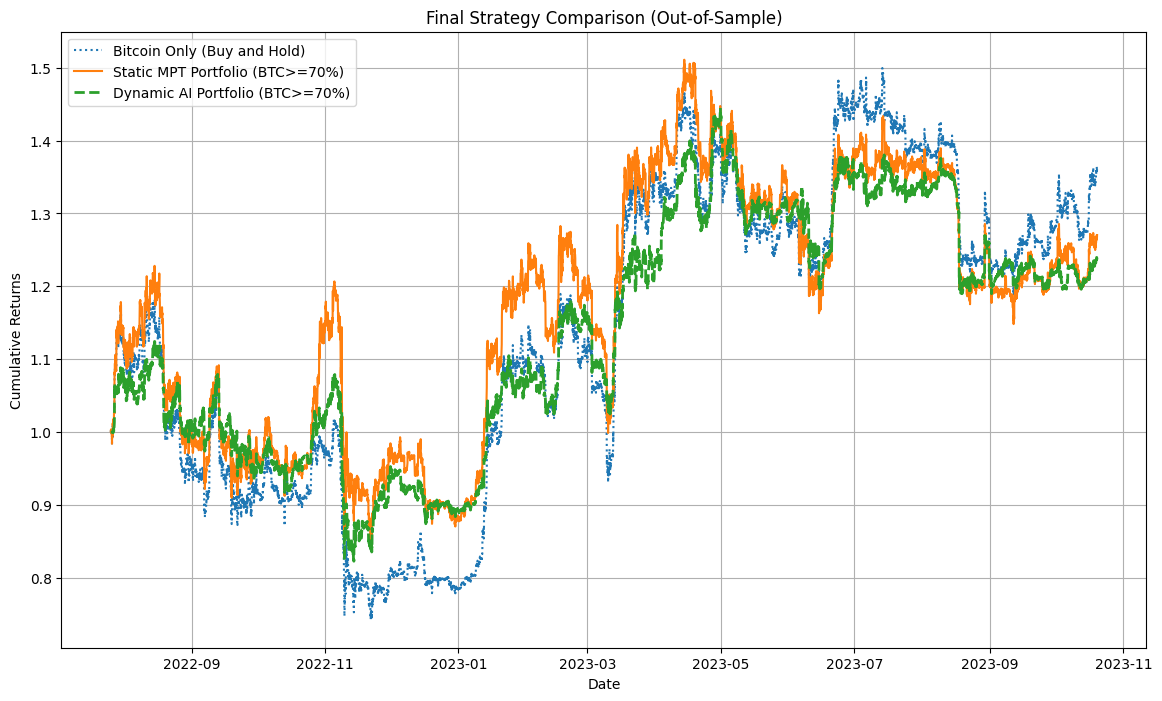

In [17]:
# Final Visualization
plt.figure(figsize=(14, 8))
plt.plot(cumulative_btc_returns.index, cumulative_btc_returns, label='Bitcoin Only (Buy and Hold)', linestyle=':')
plt.plot(cumulative_static_portfolio_returns.index, cumulative_static_portfolio_returns, label='Static MPT Portfolio (BTC>=70%)')
plt.plot(cumulative_dynamic_portfolio_returns.index, cumulative_dynamic_portfolio_returns, label='Dynamic AI Portfolio (BTC>=70%)', linewidth=2, linestyle='--')
plt.title('Final Strategy Comparison (Out-of-Sample)')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

presentation for the project is available in the same github repo